# Sage Shaw

### ME 571 - Spring 2018

# HW 1 - Problem 2

### See separate notebook for the Median of Medians

In [1]:
%matplotlib inline
import collections
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd

from random import random, shuffle
from itertools import repeat
from statistics import median
from time import sleep

# In Serial

In [28]:
def serial_mean(lst):
    return sum(lst)/len(lst)
def serial_sd(lst, u=None):
    if u==None:
        u = serial_mean(lst)
    return sum([(x-u)**2 for x in lst])/(len(lst) - 1)

# In Parallel

### Parallel Mean

In [3]:
def parallel_mean1(lst, p):
    pool = mp.Pool(processes = p)
    l = len(lst)
    size = l//p + 1
    my_lst = [lst[i:i + size] for i in range(0, l, size)]
    my_lst = pool.map(sum, my_lst)
    pool.close()
    pool.join()
    return sum(my_lst)/len(lst)
    

In [4]:
def proc_sum3(args):
    lst, i, size = args[0], args[1], args[2]
    my_sum = 0
    for num in lst[i*size:(i+1)*size]:
        my_sum+= num
    return sum(lst[i*size:(i+1)*size])

def parallel_mean3(lst,p):
    manager = mp.Manager()
    shared_list = manager.list(lst)
    pool = mp.Pool(processes = p)
    l = len(lst)
    size = l//p + 1
    sums = pool.map(proc_sum3, [(shared_list, i,size) for i in range(p)])
    pool.close()
    pool.join()
    return sum(sums)/l

In [5]:
def proc_sum4(i, size, lst, ret_list):
    #lst, i, size = args[0], args[1], args[2]
    my_sum = 0
    for num in lst[i*size:(i+1)*size]:
        my_sum+= num
    ret_list[i] = sum(lst[i*size:(i+1)*size])
    return 

def parallel_mean4(lst,p):
    manager = mp.Manager()
    shared_list = manager.list(lst)
    ret_list = manager.list([0]*p)
    #pool = mp.Pool(processes = p)
    l = len(lst)
    size = l//p + 1
    jobs = [mp.Process(target=proc_sum4, args=(i, size, shared_list, ret_list)) for i in range(p)]
    #sums = pool.map(proc_sum, [(shared_list, i,size) for i in range(p)])
    for job in jobs: job.start()
    for job in jobs: job.join()
    return sum(ret_list)/l

In [6]:
def proc_sum5(args):
    lst, i, size = args[0], args[1], args[2]
    my_sum = 0
    for num in lst[i*size:(i+1)*size]:
        my_sum+= num
    return sum(lst[i*size:(i+1)*size])

def parallel_mean5(lst,p):
    manager = mp.Manager()
    shared_list = manager.Array('f',lst)
    pool = mp.Pool(processes = p)
    l = len(lst)
    size = l//p + 1
    sums = pool.map(proc_sum3, [(shared_list, i,size) for i in range(p)])
    pool.close()
    pool.join()
    return sum(sums)/l

In [3]:
def proc_sum6(i, size, lst, ret_list):
    ret_list[i] = sum(lst[i*size:(i+1)*size])
    return 

def parallel_mean6(lst,p):
    manager = mp.Manager()
    shared_list = manager.list(lst)
    ret_list = manager.list([0]*p)
    #pool = mp.Pool(processes = p)
    l = len(lst)
    size = l//p + 1
    jobs = [mp.Process(target=proc_sum6, args=(i, size, shared_list, ret_list)) for i in range(p)]
    #sums = pool.map(proc_sum, [(shared_list, i,size) for i in range(p)])
    for job in jobs: job.start()
    for job in jobs: job.join()
    return sum(ret_list)/l

parallel_mean = parallel_mean6

### Parallel Mean Testings

In [4]:
N = 10**8
lst = [random() for i in range(N)]
u_serial = serial_mean(lst)
p = mp.cpu_count()

In [18]:
%%timeit
parallel_mean1(lst,p)

10 loops, best of 3: 159 ms per loop


In [20]:
%%timeit
parallel_mean3(lst,p)

10 loops, best of 3: 181 ms per loop


In [21]:
%%timeit
parallel_mean4(lst,p)

10 loops, best of 3: 88.5 ms per loop


In [22]:
%%timeit
parallel_mean5(lst,p)

10 loops, best of 3: 180 ms per loop


In [6]:
%%timeit
parallel_mean6(lst,p)

1 loop, best of 3: 17.5 s per loop


### Mean Verifications

In [8]:
N = 10**4
tolerance = 10**-8

p = mp.cpu_count()
lst = [random() for i in range(N)]
u_serial = serial_mean(lst)
assert u_serial - parallel_mean1(lst,p) < tolerance
assert u_serial - parallel_mean3(lst,p) < tolerance
assert u_serial - parallel_mean4(lst,p) < tolerance
assert u_serial - parallel_mean5(lst,p) < tolerance
assert u_serial - parallel_mean6(lst,p) < tolerance

### Parallel Standard Deviation

In [9]:
def proc_sd(i, u, size, lst, ret_list):
    ret_list[i] = sum([ (x-u)**2  for x in lst[i*size:(i+1)*size] ])
    return

def parallel_sd(lst,p, u=None):
    if u == None:
        u = parallel_mean(lst,p)
        
    manager = mp.Manager()
    shared_list = manager.list(lst)
    ret_list = manager.list([0]*p)
    l = len(lst)
    size = l//p + 1
    jobs = [mp.Process(target=proc_sd, args=(i, u, size, shared_list, ret_list)) for i in range(p)]
    for job in jobs: job.start()
    for job in jobs: job.join()
    return sum(ret_list)/(l-1)

### Standard Deviation Verification

In [10]:
N = 10**4
tolerance = 10**-8

p = mp.cpu_count()
lst = [random() for i in range(N)]

sd_serial = serial_sd(lst)
assert sd_serial - parallel_sd(lst,1) < tolerance

### Parallel Min & Max

In [34]:
def parallel_extreme(lst, p, ext=min):
    assert (ext==min or ext==max)
    sublists = [list(lst[i::p]) for i in range(p)]
    pool = mp.Pool(processes = p)
    mins = pool.map(ext, sublists)
    pool.close()
    pool.join()
    return ext(mins)

def parallel_min(lst, p):
    return parallel_extreme(lst,p)

def parallel_max(lst,p):
    return parallel_extreme(lst, p, ext=max)

### Min verification

In [43]:
N = 10**5

p = mp.cpu_count()
lst = [random() for i in range(N)]

my_min = min(lst)
my_max = max(lst)

In [44]:
assert parallel_min(lst,16) == my_min
assert parallel_max(lst,16) == my_max

# Times

In [37]:
N = 10**5
lst = [random() for i in range(N)]

columns = ['Time', 'Processors', 'Speed-Up', 'Efficiency', 'Theoretical Speed-Up', 'Theoretical Efficiency']
mean_data = pd.DataFrame(columns=columns)
sd_data = pd.DataFrame(columns=columns)
min_data = pd.DataFrame(columns=columns)
max_data = pd.DataFrame(columns=columns)

In [2]:
def stats_from_timeit(timeit_result, num_proc, description):
    t = timeit_result.best
    data_row = {'Time': t, 'Processors': num_proc}
    return pd.Series(data=data_row, name=description)

### Mean Times

In [69]:
my_time = %timeit -o w = serial_mean(lst)
mean_data = mean_data.append(stats_from_timeit(my_time, 1, 'Serial'))
T0 = my_time.best

100 loops, best of 3: 6.61 ms per loop


In [70]:
process_counts = range(0, int(np.log(mp.cpu_count())/np.log(2))+3)
process_counts = [2**p for p in process_counts]

for p in process_counts:
    my_time = %timeit -o w = parallel_mean(lst,p)
    mean_data = mean_data.append(stats_from_timeit(my_time, p, 'Parallel'))

1 loop, best of 3: 469 ms per loop
1 loop, best of 3: 463 ms per loop
1 loop, best of 3: 513 ms per loop
1 loop, best of 3: 696 ms per loop
1 loop, best of 3: 1.07 s per loop
1 loop, best of 3: 1.85 s per loop
1 loop, best of 3: 3.41 s per loop


In [71]:
mean_data['Speed-Up'] = T0/mean_data['Time']
mean_data['Efficiency'] = mean_data['Speed-Up']/mean_data['Processors']
mean_data['Theoretical Speed-Up'] = mean_data['Processors']
mean_data['Theoretical Efficiency'] = 1

In [72]:
mean_data

,Time,Processors,Speed-Up,Efficiency,Theoretical Speed-Up,Theoretical Efficiency
Serial,0.006607,1.0,1.000000,1.000000,1.0,1
Parallel,0.468722,1.0,0.014095,0.014095,1.0,1
Parallel,0.463141,2.0,0.014265,0.007133,2.0,1
Parallel,0.513400,4.0,0.012869,0.003217,4.0,1
Parallel,0.695732,8.0,0.009496,0.001187,8.0,1
Parallel,1.072743,16.0,0.006159,0.000385,16.0,1
Parallel,1.849156,32.0,0.003573,0.000112,32.0,1
Parallel,3.414265,64.0,0.001935,0.000030,64.0,1


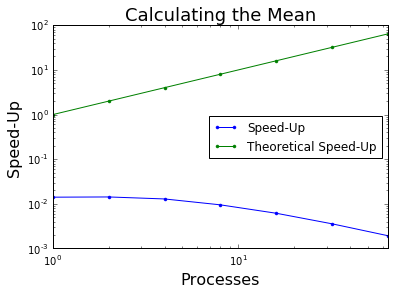

In [73]:
parallel_data = mean_data.loc['Parallel'][['Processors','Speed-Up','Theoretical Speed-Up']]
plt = parallel_data.plot(x='Processors',style='.-', loglog=True)
plt.set_title('Calculating the Mean',fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Speed-Up',fontsize=16);

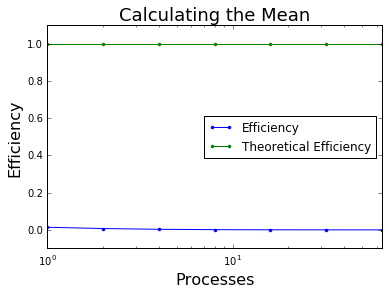

In [87]:
parallel_data = mean_data.loc['Parallel'][['Processors','Efficiency','Theoretical Efficiency']]
plt = parallel_data.plot(x='Processors',style='.-', logx=True)
plt.set_title("Calculating the Mean",fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Efficiency',fontsize=16);
plt.set_ylim(-0.1, 1.1);

### SD Times

In [75]:
my_time = %timeit -o w = serial_sd(lst)
sd_data = sd_data.append(stats_from_timeit(my_time, 1, 'Serial'))
T0 = my_time.best

1 loop, best of 3: 207 ms per loop


In [76]:
process_counts = range(0, int(np.log(mp.cpu_count())/np.log(2))+3)
process_counts = [2**p for p in process_counts]

for p in process_counts:
    my_time = %timeit -o w = parallel_sd(lst,p)
    sd_data = sd_data.append(stats_from_timeit(my_time, p, 'Parallel'))

1 loop, best of 3: 1.13 s per loop
1 loop, best of 3: 1.01 s per loop
1 loop, best of 3: 1.07 s per loop
1 loop, best of 3: 1.42 s per loop
1 loop, best of 3: 2.15 s per loop
1 loop, best of 3: 3.78 s per loop
1 loop, best of 3: 6.83 s per loop


In [79]:
sd_data['Speed-Up'] = T0/sd_data['Time']
sd_data['Efficiency'] = sd_data['Speed-Up']/sd_data['Processors']
sd_data['Theoretical Speed-Up'] = sd_data['Processors']
sd_data['Theoretical Efficiency'] = 1
sd_data

,Time,Processors,Speed-Up,Efficiency,Theoretical Speed-Up,Theoretical Efficiency
Serial,0.206555,1.0,1.000000,1.000000,1.0,1
Parallel,1.130122,1.0,0.182773,0.182773,1.0,1
Parallel,1.005594,2.0,0.205406,0.102703,2.0,1
Parallel,1.074091,4.0,0.192307,0.048077,4.0,1
Parallel,1.416384,8.0,0.145833,0.018229,8.0,1
Parallel,2.149617,16.0,0.096089,0.006006,16.0,1
Parallel,3.778874,32.0,0.054661,0.001708,32.0,1
Parallel,6.833995,64.0,0.030225,0.000472,64.0,1


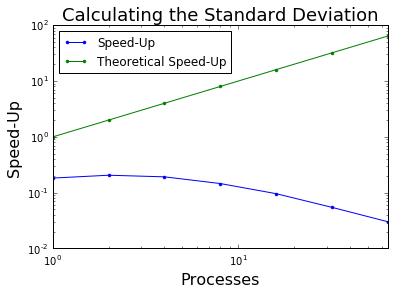

In [80]:
parallel_data = sd_data.loc['Parallel'][['Processors','Speed-Up','Theoretical Speed-Up']]
plt = parallel_data.plot(x='Processors',style='.-', loglog=True)
plt.set_title('Calculating the Standard Deviation',fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Speed-Up',fontsize=16);

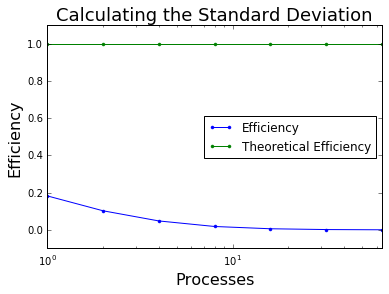

In [86]:
parallel_data = sd_data.loc['Parallel'][['Processors','Efficiency','Theoretical Efficiency']]
plt = parallel_data.plot(x='Processors',style='.-', logx=True)
plt.set_title("Calculating the Standard Deviation",fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Efficiency',fontsize=16);
plt.set_ylim(-0.1, 1.1);

### Min Times

In [30]:
my_time = %timeit -o w = min(lst)
min_data = min_data.append(stats_from_timeit(my_time, 1, 'Serial'))
T0 = my_time.best

process_counts = range(0, int(np.log(mp.cpu_count())/np.log(2))+3)
process_counts = [2**p for p in process_counts]

for p in process_counts:
    my_time = %timeit -o w = parallel_min(lst,p)
    min_data = min_data.append(stats_from_timeit(my_time, p, 'Parallel'))
    
min_data['Speed-Up'] = T0/min_data['Time']
min_data['Efficiency'] = min_data['Speed-Up']/min_data['Processors']
min_data['Theoretical Speed-Up'] = min_data['Processors']
min_data['Theoretical Efficiency'] = 1
min_data

100 loops, best of 3: 2.74 ms per loop
10 loops, best of 3: 109 ms per loop
10 loops, best of 3: 113 ms per loop
10 loops, best of 3: 120 ms per loop
10 loops, best of 3: 135 ms per loop
10 loops, best of 3: 164 ms per loop
1 loop, best of 3: 224 ms per loop
1 loop, best of 3: 355 ms per loop


,Time,Processors,Speed-Up,Efficiency,Theoretical Speed-Up,Theoretical Efficiency
Serial,0.002741,1.0,1.000000,1.000000,1.0,1
Parallel,0.108959,1.0,0.025160,0.025160,1.0,1
Parallel,0.112549,2.0,0.024358,0.012179,2.0,1
Parallel,0.120402,4.0,0.022769,0.005692,4.0,1
Parallel,0.134983,8.0,0.020310,0.002539,8.0,1
Parallel,0.164480,16.0,0.016667,0.001042,16.0,1
Parallel,0.223997,32.0,0.012239,0.000382,32.0,1
Parallel,0.355493,64.0,0.007712,0.000120,64.0,1


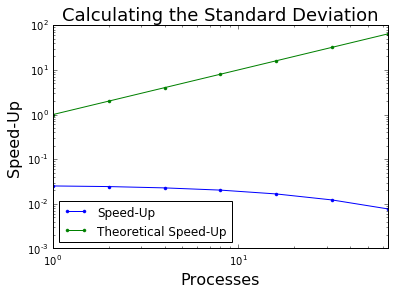

In [31]:
parallel_data = min_data.loc['Parallel'][['Processors','Speed-Up','Theoretical Speed-Up']]
plt = parallel_data.plot(x='Processors',style='.-', loglog=True)
plt.set_title('Calculating the Standard Deviation',fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Speed-Up',fontsize=16);

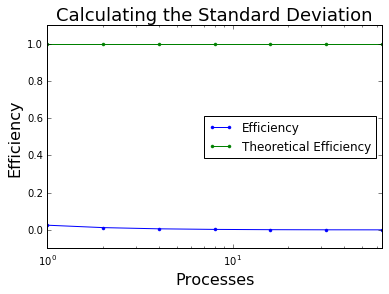

In [32]:
parallel_data = min_data.loc['Parallel'][['Processors','Efficiency','Theoretical Efficiency']]
plt = parallel_data.plot(x='Processors',style='.-', logx=True)
plt.set_title("Calculating the Standard Deviation",fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Efficiency',fontsize=16);
plt.set_ylim(-0.1, 1.1);

### Max Times

In [40]:
my_time = %timeit -o w = max(lst)
max_data = max_data.append(stats_from_timeit(my_time, 1, 'Serial'))
T0 = my_time.best

process_counts = range(0, int(np.log(mp.cpu_count())/np.log(2))+3)
process_counts = [2**p for p in process_counts]

for p in process_counts:
    my_time = %timeit -o w = parallel_max(lst,p)
    max_data = max_data.append(stats_from_timeit(my_time, p, 'Parallel'))
    
max_data['Speed-Up'] = T0/max_data['Time']
max_data['Efficiency'] = max_data['Speed-Up']/max_data['Processors']
max_data['Theoretical Speed-Up'] = max_data['Processors']
max_data['Theoretical Efficiency'] = 1
max_data

100 loops, best of 3: 2.75 ms per loop
10 loops, best of 3: 111 ms per loop
10 loops, best of 3: 116 ms per loop
10 loops, best of 3: 124 ms per loop
10 loops, best of 3: 142 ms per loop
10 loops, best of 3: 178 ms per loop
1 loop, best of 3: 240 ms per loop
1 loop, best of 3: 392 ms per loop


,Time,Processors,Speed-Up,Efficiency,Theoretical Speed-Up,Theoretical Efficiency
Serial,0.002762,1.0,0.994790,0.994790,1.0,1
Serial,0.002747,1.0,1.000000,1.000000,1.0,1
Parallel,0.111125,1.0,0.024722,0.024722,1.0,1
Parallel,0.115689,2.0,0.023747,0.011874,2.0,1
Parallel,0.124415,4.0,0.022082,0.005520,4.0,1
Parallel,0.142175,8.0,0.019323,0.002415,8.0,1
Parallel,0.178088,16.0,0.015427,0.000964,16.0,1
Parallel,0.240327,32.0,0.011431,0.000357,32.0,1
Parallel,0.392232,64.0,0.007004,0.000109,64.0,1


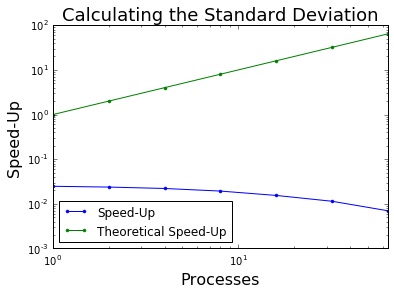

In [41]:
parallel_data = max_data.loc['Parallel'][['Processors','Speed-Up','Theoretical Speed-Up']]
plt = parallel_data.plot(x='Processors',style='.-', loglog=True)
plt.set_title('Calculating the Standard Deviation',fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Speed-Up',fontsize=16);

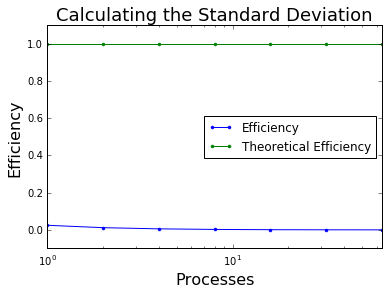

In [42]:
parallel_data = max_data.loc['Parallel'][['Processors','Efficiency','Theoretical Efficiency']]
plt = parallel_data.plot(x='Processors',style='.-', logx=True)
plt.set_title("Calculating the Standard Deviation",fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Efficiency',fontsize=16);
plt.set_ylim(-0.1, 1.1);

# Analysis

These parallelized algorithms are horrible!!!

They are so much slower than performing the calculation in serial. The more processes are allocated, the longer it takes - the exact opposite expected when parallelizing computations. While these processes were running, I was watching the cpu load per core using $\textbf{top}$ - a linux program for monitoring system processes. Regardless of the size of the list, there would be long periods where only one core was being used followed by short bursts where more cores were used. It appears that these implementations spend much more time dividing up the list than they do actually calculating the values. 

We can test this by pre-splitting the list.

In [51]:
def proc_sum_divided(i, lst,ret_list):
    ret_list[i] = sum(lst)
    return 

def parallel_mean_divided(lists):
    manager = mp.Manager()
    ret_list = manager.list([0]*len(lists))
    jobs = [mp.Process(target=proc_sum_divided, args=(i, lst, ret_list) ) for i, lst in enumerate(lists)]
    for job in jobs: job.start()
    for job in jobs: job.join()
    return sum(ret_list)/sum([len(lst) for lst in lists])

In [52]:
N = 2 * 10**8
lst = [random() for i in range(N)]

columns = ['Time', 'Processors', 'Speed-Up', 'Efficiency', 'Theoretical Speed-Up', 'Theoretical Efficiency']
divided_data = pd.DataFrame(columns=columns)

In [53]:
my_time = %timeit -o w = serial_mean(lst)
divided_data = divided_data.append(stats_from_timeit(my_time, 1, 'Serial'))
T0 = my_time.best

1 loop, best of 3: 1.35 s per loop


In [54]:
process_counts = range(0, int(np.log(mp.cpu_count())/np.log(2))+3)
process_counts = [2**p for p in process_counts]

for p in process_counts:
    l = len(lst)
    size = l//p + 1
    lists = [lst[i*size:(i+1)*size] for i in range(p)]
    my_time = %timeit -o w = parallel_mean_divided(lists)
    divided_data = divided_data.append(stats_from_timeit(my_time, p, 'Parallel'))

1 loop, best of 3: 5.13 s per loop
1 loop, best of 3: 2.84 s per loop
1 loop, best of 3: 1.81 s per loop
1 loop, best of 3: 1.58 s per loop
1 loop, best of 3: 1.93 s per loop
1 loop, best of 3: 3.07 s per loop
1 loop, best of 3: 5.68 s per loop


In [55]:
divided_data['Speed-Up'] = T0/divided_data['Time']
divided_data['Efficiency'] = divided_data['Speed-Up']/divided_data['Processors']
divided_data['Theoretical Speed-Up'] = divided_data['Processors']
divided_data['Theoretical Efficiency'] = 1
divided_data

,Time,Processors,Speed-Up,Efficiency,Theoretical Speed-Up,Theoretical Efficiency
Serial,1.352432,1.0,1.000000,1.000000,1.0,1
Parallel,5.130235,1.0,0.263620,0.263620,1.0,1
Parallel,2.843898,2.0,0.475556,0.237778,2.0,1
Parallel,1.813617,4.0,0.745709,0.186427,4.0,1
Parallel,1.583323,8.0,0.854173,0.106772,8.0,1
Parallel,1.928213,16.0,0.701391,0.043837,16.0,1
Parallel,3.074654,32.0,0.439865,0.013746,32.0,1
Parallel,5.678622,64.0,0.238162,0.003721,64.0,1


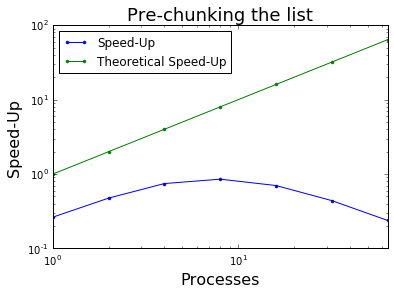

In [56]:
parallel_data = divided_data.loc['Parallel'][['Processors','Speed-Up','Theoretical Speed-Up']]
plt = parallel_data.plot(x='Processors',style='.-', loglog=True)
plt.set_title('Pre-chunking the list',fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Speed-Up',fontsize=16);

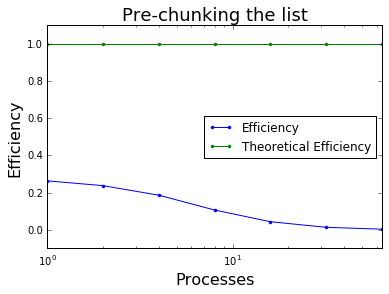

In [57]:
parallel_data = divided_data.loc['Parallel'][['Processors','Efficiency','Theoretical Efficiency']]
plt = parallel_data.plot(x='Processors',style='.-', logx=True)
plt.set_title("Pre-chunking the list",fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Efficiency',fontsize=16);
plt.set_ylim(-0.1, 1.1);

These results weakly support the hypothesis in that they do show much more improvement as the number of cores goes up, but they are still laughably slower than the simple way of performing the calculations in serial. 

# Calculating the Median

## Note:
I took another crack at the Median of Medians and got it working. I put it in a separate file to keep it clean. 

In [3]:
N = 10**1
lst = [random() for i in range(N)]

In [3]:
print(median(lst))

0.4988558972724747


In [2]:
#Failed Attempt

def partition(MoM_value, lst):
    return [x for x in lst if x<MoM_value], [x for x in lst if x>=MoM_value]

def quick_select(rank, lst):
    #returns left_list, median, right_list
    #currently not actually a quick select. This is a standin for a quick select
    
    #cases of list very small
    if not isinstance(lst, collections.Iterable):
        lst = [lst]
    if len(lst) == 1: 
        return [], lst[0], []
    elif rank >= len(lst): 
        my_max = max(lst)
        return lst.remove(my_max), my_max, []
    
    #not small, find selected value
    my_lst = sorted(lst)
    if rank == 0:
        return [], my_lst[0], my_lst[1:]
    elif rank == len(lst)-1:
        return my_lst[:-1], my_lst[-1], []
    else:
        return my_lst[:rank-1], my_lst[rank], my_lst[rank+1:]

    
def proc_task(i, rank, lst, children_medians, barrier, MoM, return_lists, discard_left, len_left):
    left, med, right = quick_select(rank, lst)
    children_medians[i] = med
    
    barrier.wait() #release the parent
    sleep(10**-3)
    barrier.wait() #wait for parent to find MoM
    #partition list
    left, right = partition(MoM.value, lst)
    len_left[i] = len(left)
    barrier.wait() #wait for parent, then discard list
    sleep(10**-3)
    if discard_left[i]:
        return_lists.put(right)
    else:
        return_lists.put(left)
    return
    
def MoM_step(rank, lst, p, barrier):
    sublists = [list(lst[i::p]) for i in range(p)]
    children_medians = mp.Array('f', [0]*p)
    len_left = mp.Array('i', [0]*p)
    return_lists = mp.Queue()
    
    MoM = mp.Value('f',0)
    
    #discard_left = mp.Value('b',False)
    discard_left = mp.Array('b', [False]*p)
    
    jobs = [
        mp.Process(
            target=proc_task, 
            args=(i, rank//p, sublist, children_medians, barrier, MoM, return_lists, discard_left, len_left)
        )
        for i, sublist in enumerate(sublists)]
    
    for job in jobs: job.start()
    #wait for children to find medians
    barrier.wait()
    #calculate MoM
    MoM.value = quick_select(p//2, list(children_medians))[1]
    #print('MoM: %f' % MoM.value)
    barrier.wait() #let children resume
    sleep(10**-3)
    #wait for children to partition lists
    barrier.wait()
    #tell children which to discard
    count_left = sum(len_left)
    #print('sum_len_left: %d' % count_left)
    old_rank = rank
    if count_left < rank:
        for i in range(p):
            discard_left[i] = True
        rank -= count_left
    else:
        for i in range(p):
            discard_left[i] = False
        
    print('rank reduced from %d to %d' % (old_rank, rank))
    
    #wait for children to return lists
    for job in jobs: job.join()
    
    
    #rank -= sum(removed_from_left)
    
    new_list = []
    while not return_lists.empty():
        #l = return_lists.get()
        #print(l)
        new_list += return_lists.get()
    #print('New list size: %d' % len(new_list))
    return rank, new_list

def median_parallel(lst,p):
    rank = len(lst)//2
    print('starting rank: %d' % rank)
    barrier = mp.Barrier(p+1)
    while len(lst)>max(p*3,30):
        #print('Failed: %r' % (not 50 in lst))
        #print('input rank: %d, list len: %d' % (rank, len(lst)))
        rank, lst = MoM_step(rank, lst, p, barrier)
        #print('%d left' % len(lst))
        #print(lst)
    #print(lst)
    return quick_select(rank,lst)[1]
    
    
    
    

In [ ]:
lst = list(range(10**5))
shuffle(lst)

print(median_parallel(lst,16))

starting rank: 50000
rank reduced from 50000 to 50000


In [176]:
a = list(range(10))
partition(10,a)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [])

In [13]:
#Failed Attempt

def partition(MoM_value, lst):
    return [x for x in lst if x<MoM_value], [x for x in lst if x>=MoM_value]

def quick_select(rank, lst):
    #returns left_list, median, right_list
    #currently not actually a quick select. This is a standin for a quick select
    
    #cases of list very small
    if len(lst) == 0:
        return None
    if not isinstance(lst, collections.Iterable):
        lst = [lst]
    if len(lst) == 1: 
        return [], lst[0], []
    elif rank >= len(lst): 
        my_max = max(lst)
        return lst.remove(my_max), my_max, []
    
    #not small, find selected value
    my_lst = sorted(lst)
    if rank == 0:
        return [], my_lst[0], my_lst[1:]
    elif rank == len(lst)-1:
        return my_lst[:-1], my_lst[-1], []
    else:
        return my_lst[:rank-1], my_lst[rank], my_lst[rank+1:]

    
def proc_task(i, rank, lst, children_medians, parent_go, children_go, MoM, return_lists, discard_left, len_left):
    left, med, right = quick_select(rank, lst)
    children_medians[i] = med
    
    parent_go.set() #release the parent
    children_go.wait() #wait for parent to find MoM
    children_go.clear()
    #partition list
    left, right = partition(MoM.value, lst)
    len_left[i] = len(left)
    parent_go.set() #wait for parent, then discard list
    children_go.wait() 
    children_go.clear()
    if discard_left[i]:
        return_lists.put(right)
    else:
        return_lists.put(left)
    return
    
def MoM_step(rank, lst, p, parent_go, children_go):
    sublists = [list(lst[i::p]) for i in range(p)]
    children_medians = mp.Array('f', [0]*p)
    len_left = mp.Array('i', [0]*p)
    return_lists = mp.Queue()
    
    MoM = mp.Value('f',0)
    
    #discard_left = mp.Value('b',False)
    discard_left = mp.Array('b', [False]*p)
    
    jobs = [
        mp.Process(
            target=proc_task, 
            args=(i, rank//p, sublist, children_medians, parent_go[i], children_go, MoM, return_lists, discard_left, len_left)
        )
        for i, sublist in enumerate(sublists)]
    
    for job in jobs: job.start()
    #wait for children to find medians
    for e in parent_go:
        e.wait()
    for e in parent_go:
        e.clear()
    
    #calculate MoM
    MoM.value = quick_select(p//2, list(children_medians))[1]
    #print('MoM: %f' % MoM.value)
    children_go.set() #let children resume
    #wait for children to partition lists
    for e in parent_go:
        e.wait()
    for e in parent_go:
        e.clear()
    
    #tell children which to discard
    count_left = sum(len_left)
    #print('sum_len_left: %d' % count_left)
    old_rank = rank
    if count_left < rank:
        for i in range(p):
            discard_left[i] = True
        rank -= count_left
    else:
        for i in range(p):
            discard_left[i] = False
        
    print('rank reduced from %d to %d' % (old_rank, rank))
    
    #wait for children to return lists
    children_go.set()
    for job in jobs: job.join()
    
    
    #rank -= sum(removed_from_left)
    
    new_list = []
    while not return_lists.empty():
        #l = return_lists.get()
        #print(l)
        new_list += return_lists.get()
    #print('New list size: %d' % len(new_list))
    return rank, new_list

def median_parallel(lst,p):
    rank = len(lst)//2
    print('starting rank: %d' % rank)
    #barrier = mp.Barrier(p+1)
    parent_go = [mp.Event() for i in range(p)]
    children_go = mp.Event()
    while len(lst)>max(p*3,30):
        #print('Failed: %r' % (not 50 in lst))
        #print('input rank: %d, list len: %d' % (rank, len(lst)))
        rank, lst = MoM_step(rank, lst, p, parent_go, children_go)
        #print('%d left' % len(lst))
        #print(lst)
    #print(lst)
    return quick_select(rank,lst)[1]
    
    

In [20]:
lst = list(range(10**3))
shuffle(lst)

print(median_parallel(lst,4))

500


# A Note on the Parallelizing the Median

**Update: It is working now. See below... **

I have gotten close, but as of yet I have been unable to produce a reliable implementation of the Median of Medians algorithm. 

Firstly, this algorithm requires some sort of quick select since it needs to be able to find an element of a list of a given rank. At first this rank is half the size of the list, but as elements get eliminated from the list, the required rank on each search goes down. The median of a list of 100 elements is the same as the second smallest element in the top 52 elements. I decided to use a slow stand-in until I could get the interesting parts of the algorithm working. Since I haven't succeeded at that, I see no reason to write my own quick sort.

It seems to be very difficult to allow for child processes to wait for the parent process to compute before continuing. From my testing using the **sleep** function, I have determined that using **barriers** is not an effective way to comunicate with the parent process, although it is perfectly effective at communicating with sibling processes. Using **events** seems better, but this has introduced new bugs to the code I have.

Presently, the code I have will often run if there are up to 1,000 elements in the list and if it doesn't stall, it will return a value close to the median if not the median itself. 

In [5]:
#"Successful" Attempt

def partition(MoM_value, lst):
    return [x for x in lst if x<MoM_value], [x for x in lst if x>=MoM_value]

def quick_select(rank, lst):
    #returns left_list, median, right_list
    #currently not actually a quick select. This is a standin for a quick select
    
    #cases of list very small
    if not isinstance(lst, collections.Iterable):
        lst = [lst]        
    if len(lst) == 1: 
        return [], lst[0], []
    elif rank >= len(lst): 
        my_max = max(lst)
        return lst.remove(my_max), my_max, []
    
    #not small, find selected value
    my_lst = sorted(lst)
    if rank == 0:
        return [], my_lst[0], my_lst[1:]
    elif rank == len(lst)-1:
        return my_lst[:-1], my_lst[-1], []
    else:
        return my_lst[:rank-1], my_lst[rank], my_lst[rank+1:]

    
def proc_select(i, rank, lst, children_medians):
    left, med, right = quick_select(rank, lst)
    children_medians[i] = med
    return

def proc_partition(i, lst, MoM, left_lists, right_lists, left_lengths):
    left, right = partition(MoM, lst)
    left_lengths[i] = len(left)
    right_lists.put(right)
    left_lists.put(left)
    return
    
    
def MoM_step(rank, lst, p, barrier):
    sublists = [list(lst[i::p]) for i in range(p)]
    children_medians = mp.Array('f', [0]*p)
    left_lists = mp.Queue()
    right_lists = mp.Queue()
    left_lengths = mp.Array('i', [0]*p)
    
    #find medians
    jobs = [
        mp.Process(
            target=proc_select, 
            args=(i, rank//p, sublist, children_medians)
        )
        for i, sublist in enumerate(sublists)]
    
    for job in jobs: job.start()
    for job in jobs: job.join()
        
    MoM = quick_select(p//2, list(children_medians))[1]
    
    #partition list
    jobs = [
        mp.Process(
            target=proc_partition, 
            args=(i, sublist, MoM, left_lists, right_lists, left_lengths)
        )
        for i, sublist in enumerate(sublists)]
    
    for job in jobs: job.start()
    for job in jobs: job.join()
    
    count_left = sum(left_lengths)

    new_list = []
    
    old_rank = rank
    if count_left < rank:
        for i in range(p):
            while not right_lists.empty():
                new_list += right_lists.get()
        rank -= count_left
    else:
        for i in range(p):
            while not left_lists.empty():
                new_list += left_lists.get()
                
    return rank, new_list

def median_parallel(lst,p):
    rank = len(lst)//2
    #print('starting rank: %d' % rank)
    barrier = mp.Barrier(p+1)
    while len(lst)>max(p*3,30):
        #print('Failed: %r' % (not 50 in lst))
        #print('input rank: %d, list len: %d' % (rank, len(lst)))
        rank, lst = MoM_step(rank, lst, p, barrier)
        #print('%d left' % len(lst))
        #print(lst)
    #print(lst)
    return quick_select(rank,lst)[1]
    

In [30]:
lst = list(range(4*10**4))
shuffle(lst)

print(median_parallel(lst,16))

20000


# Finanl Thoughts

Well, it looks like it's working, but only for lists of about 40,000 and lower. 

In [12]:
N = 10**4
lst = list(range(N))
shuffle(lst)

columns = ['Time', 'Processors', 'Speed-Up', 'Efficiency', 'Theoretical Speed-Up', 'Theoretical Efficiency']
median_data = pd.DataFrame(columns=columns)

In [13]:
process_counts = range(0, int(np.log(mp.cpu_count())/np.log(2))+3)
process_counts = [2**p for p in process_counts]

for p in process_counts:
    my_time = %timeit -o w = median_parallel(lst, p)
    if p==1: T0 = my_time.best
    median_data = median_data.append(stats_from_timeit(my_time, p, 'Parallel'))

10 loops, best of 3: 42.3 ms per loop
10 loops, best of 3: 148 ms per loop
1 loop, best of 3: 214 ms per loop
10 loops, best of 3: 118 ms per loop
1 loop, best of 3: 404 ms per loop
1 loop, best of 3: 439 ms per loop
1 loop, best of 3: 784 ms per loop


In [14]:
median_data['Speed-Up'] = T0/median_data['Time']
median_data['Efficiency'] = median_data['Speed-Up']/median_data['Processors']
median_data['Theoretical Speed-Up'] = median_data['Processors']
median_data['Theoretical Efficiency'] = 1
median_data

,Time,Processors,Speed-Up,Efficiency,Theoretical Speed-Up,Theoretical Efficiency
Parallel,0.042303,1.0,1.000000,1.000000,1.0,1
Parallel,0.147905,2.0,0.286015,0.143008,2.0,1
Parallel,0.213961,4.0,0.197714,0.049429,4.0,1
Parallel,0.118474,8.0,0.357066,0.044633,8.0,1
Parallel,0.403996,16.0,0.104712,0.006544,16.0,1
Parallel,0.438559,32.0,0.096459,0.003014,32.0,1
Parallel,0.784342,64.0,0.053935,0.000843,64.0,1


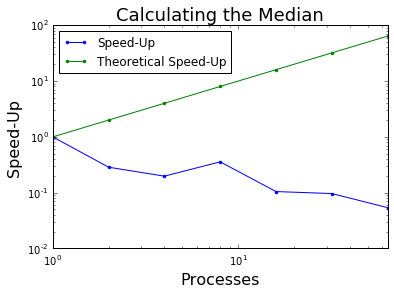

In [18]:
parallel_data = median_data.loc['Parallel'][['Processors','Speed-Up','Theoretical Speed-Up']]
plt = parallel_data.plot(x='Processors',style='.-', loglog=True)
plt.set_title('Calculating the Median',fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Speed-Up',fontsize=16);

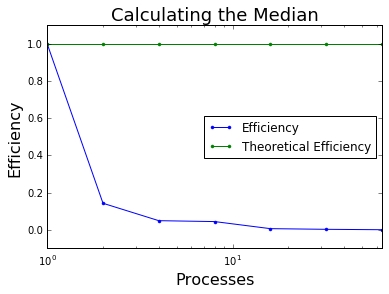

In [19]:
parallel_data = median_data.loc['Parallel'][['Processors','Efficiency','Theoretical Efficiency']]
plt = parallel_data.plot(x='Processors',style='.-', logx=True)
plt.set_title("Calculating the Median",fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Efficiency',fontsize=16);
plt.set_ylim(-0.1, 1.1);

## I took another crack at the Median of Medians and got it working. I put it in a separate file to keep it clean.